In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [156]:
sw_data=pd.read_csv("FINAL_EDGE_TABLE.csv",usecols=['Origin_Airport_Code','origin_lat','origin_long','passengers','sum_departures_performed'])
renaming={'Origin_Airport_Code':'IATA','origin_lat':'LATITUDE','origin_long':'LONGITUDE','passengers':"PASSENGERS",'sum_departures_performed':'DEPARTURES'}
sw_data.rename(columns=renaming,inplace=True)
sw_airports_location=sw_data[['IATA','LATITUDE','LONGITUDE']].drop_duplicates(keep='first').reset_index(drop=True)
sw_airports_location

,IATA,LATITUDE,LONGITUDE
0,ABQ,35.040199,-106.609001
1,ALB,42.748299,-73.801697
2,AMA,35.219398,-101.706001
3,ATL,33.636700,-84.428101
4,AUS,30.197535,-97.662015
...,...,...,...
80,SNA,33.675701,-117.867996
81,STL,38.748697,-90.370003
82,TPA,27.975500,-82.533203
83,TUL,36.198399,-95.888100


In [157]:
sw_passengers=sw_data[['IATA','DEPARTURES','PASSENGERS']]
sw_passengers=sw_passengers.groupby(['IATA']).mean().reset_index()
sw_passengers.insert(3,'AVERAGE',sw_passengers['PASSENGERS']/sw_passengers['DEPARTURES'])
sw_passengers

,IATA,DEPARTURES,PASSENGERS,AVERAGE
0,ABQ,254.888889,29756.222222,116.741935
1,ALB,176.166667,22521.000000,127.839167
2,AMA,254.500000,23229.500000,91.275049
3,ATL,320.166667,36946.388889,115.397362
4,AUS,214.000000,25781.076923,120.472322
...,...,...,...,...
80,SNA,675.428571,79748.142857,118.070431
81,STL,247.976190,29830.880952,120.297360
82,TPA,222.823529,27228.205882,122.196278
83,TUL,171.400000,18482.400000,107.831972


In [4]:
#Function that calculates the haversine distance between two sets of coordinates
from sklearn.metrics.pairwise import haversine_distances
def haversine(x,y):
    R=6371 #Radius of Earth in KM
    x_rd=np.radians(x)
    y_rd=np.radians(y)
    h=(haversine_distances([x_rd,y_rd]))[0][1]
    d=R*h #Haversine Distance
    return d

In [56]:
#Function that calculates Mean Squared Error
def k_means_inertia(data,centre_labels,w):
    se=0
    for centres in np.unique(centre_labels):
        airports=data.loc[data['LABELS']==centres]
        a=airports[['LATITUDE','LONGITUDE']].values
        airport_weights=w[airports.index.tolist()]
        c_coords=data.loc[data['IATA']==centres][['LATITUDE','LONGITUDE']].values
        for i in range(a.shape[0]):
            se=se+airport_weights[i]*(haversine(list(a[i,:]),list(c_coords[0])))**2
    return se

In [57]:
#Function that runs a k-means algorithm based on haversine distance
def k_means_haversine(coordinates,codes,weights,no_of_clusters):
    #Setting some initial variables
    distance_matrix=np.zeros((codes.size,no_of_clusters))
    counter=0
    
    #Randomly chooses k points that serve as the initial cluster centres
    idx=np.random.choice(codes.size,no_of_clusters,replace=False)
    new_centres=list((codes[idx]))
    initial_centres=set(new_centres)
    old_centres=[]
    centres_coords=coordinates[idx,:]   

    #Running a loop till the cluster centres converge
    while(set(old_centres)!=set(new_centres)):

        #The cluster centres of the previous iteration become old clusters now
        old_centres=new_centres

        #Calculates the distance between each point and every centre and stores in the data matrix
        k,l=0,0
        for i in coordinates:
            for j in centres_coords:
                distance_matrix[k][l]=haversine(list(i),list(j))
                l=l+1
            l=0
            k=k+1

        #Assigns each point to a cluster
        #Labels each point with the cluster centre closest to it and adds it as an attribute to the dataframe
        labels=[]
        for i in distance_matrix:
            i=list(i)
            labels.append(new_centres[i.index(min(i))])
        sw_airports_location['LABELS']=labels

        #For each cluster, finds out the weighted average of all latitudes and longitudes (Virtual point)
        #Makes that point the cluster centre whose haversine distance from the virtual point is least
        #Assigns all new cluster centres coordinates by replacing old ones
        centres_coords=[]
        for centres in np.unique(labels):
            airports=sw_airports_location.loc[sw_airports_location['LABELS']==centres]
            a=airports[['LATITUDE','LONGITUDE']].values
            c_weights=weights[airports.index.tolist()]
            h_distances=np.zeros(a.shape[0])
            for i in range(h_distances.size):
                h_distances[i]=haversine(list(a[i,:]),[0,0])
            j=np.average(h_distances,weights=c_weights)
            centres_coords.append(a[np.argmin(np.abs(h_distances-j)),:])
        centres_coords=np.array(centres_coords)
        
        #Finding the corresponding airports to the newly found cluster centre coordinates
        new_centres=[]
        for i in centres_coords:
            new_centres.append(sw_airports_location.iloc[sw_airports_location.index[(sw_airports_location['LATITUDE']==i[0]) & 
                                                             (sw_airports_location['LONGITUDE']==i[1])].tolist()[0]]['IATA'])

        #Increasing the counter for every iteration
        counter=counter+1

        if(counter==20):
            #Algorithm did not converge
            return ([],0)

    
    #Algorithm converged
    return (new_centres,k_means_inertia(sw_airports_location,labels,weights))

In [81]:
#Defining some pre-requisite values
n=100
airport_coordinates=sw_airports_location.values[:,1:3]
airport_codes=sw_airports_location.values[:,0]
weight=np.array(sw_passengers['AVERAGE'])

In [82]:
#List of all airports
sw_airports=sw_airports_location['IATA'].tolist()
#List to maintain inertias for different k values
av_inertia=[]

#Running k_means n times for a range of values of k: 5 to 12
for k in range(5,13):
    converged_counter=0
    sum_inertia=0
    
    #Performing the algorithm until it converges n times
    #Calculating the average inertia for the n times it converged
    while(converged_counter!=n):
        _, inertia=k_means_haversine(airport_coordinates,airport_codes,weight,k)
        if(inertia!=0):
            converged_counter=converged_counter+1
            sum_inertia=sum_inertia+inertia
    av_inertia.append(sum_inertia/n)

In [83]:
av_inertia

[4694431603.037998,
 3627226150.7128882,
 2929603049.055485,
 2579939792.7894754,
 2266639973.99978,
 2059720359.030897,
 1805033029.0183225,
 1736111642.305638]

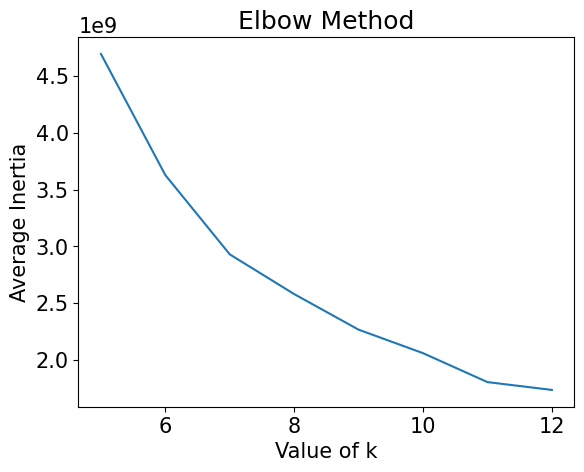

In [165]:
#Plotting the average inertias against no. of clusters
#Helps determine the ideal value of "k" via the elbow method
plt.plot(range(5,13),av_inertia)
plt.xlabel("Value of k")
plt.ylabel("Average Inertia")
plt.title("Elbow Method")
plt.show()

In [85]:
#Dictionary that stores the frequency of how many times each airport appeared as a cluster centre
cc_frequency_7={i:0 for i in sw_airports}
#Counter to check no. of times algorithm converged
converged_counter=0
#No. of clusters selected by elbow method
selected_k=7

#Run the algorithm n times for the selected k to gather sufficient data
while(converged_counter!=n):
    obtained_centres, _ =k_means_haversine(airport_coordinates,airport_codes,weight,selected_k)
    if(obtained_centres):
        converged_counter=converged_counter+1
    for i in obtained_centres:
        cc_frequency_7[i]=cc_frequency_7[i]+1

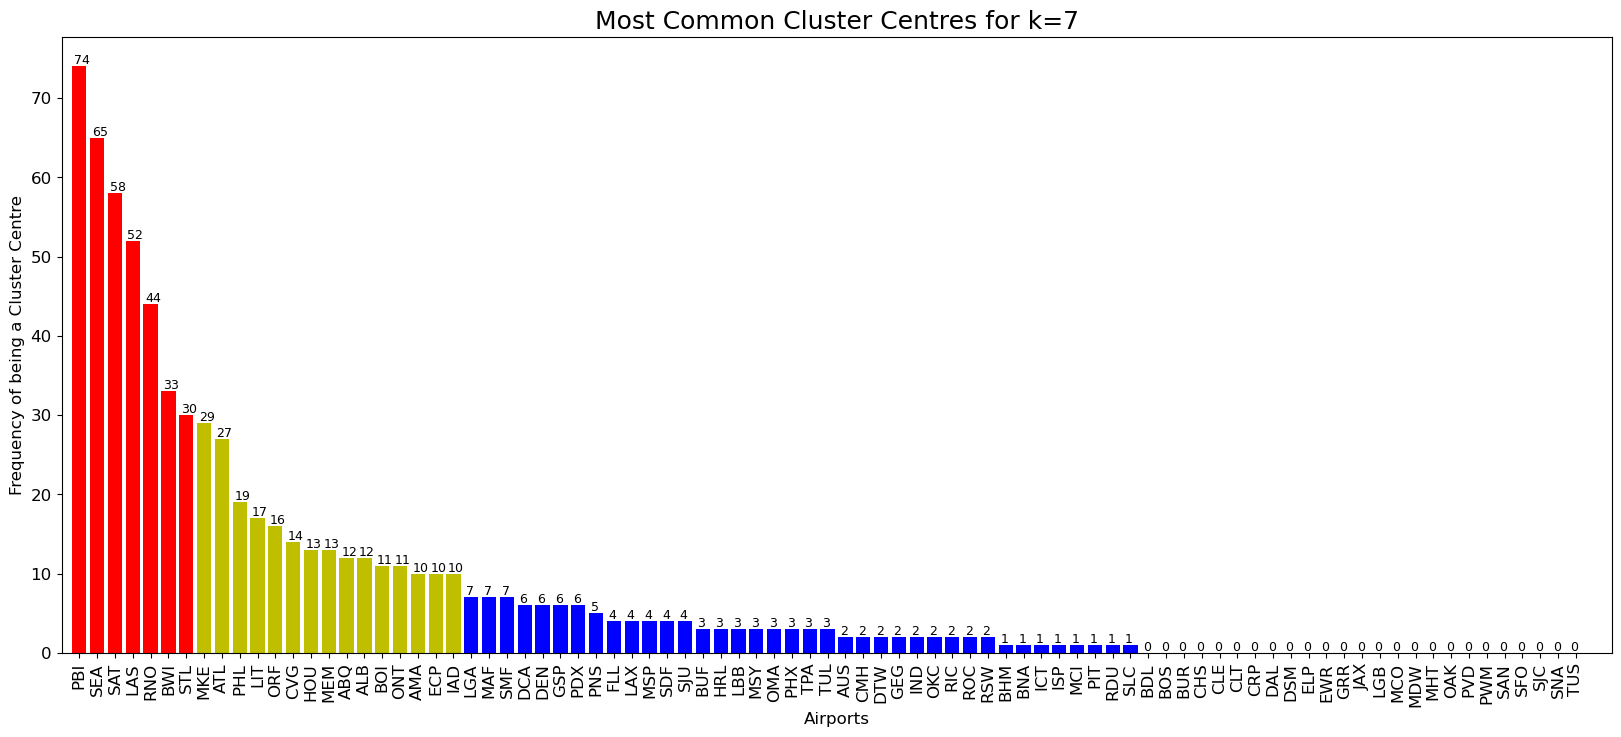

In [163]:
#New dictionary that contains sorted frequencies
common_centres_7=dict(sorted(cc_frequency_7.items(),key=lambda x:x[1],reverse=True))

#Defining a colour bar
colors_7=[]
for i in common_centres_7.values():
    if i>=30:
        colors_7.append('r')
    elif i>=10:
        colors_7.append('y')
    else:
        colors_7.append('b')

#Bar Plot
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(20,8))
plt.bar(common_centres_7.keys(), common_centres_7.values(),color=colors_7)
plt.xticks(rotation='vertical')
plt.xlim(-1,86)
plt.rcParams.update({'font.size': 9})
for index, value in enumerate(common_centres_7.values()):
    plt.text(index-0.3,value+0.3,str(value))
plt.rcParams.update({'font.size': 15})
plt.title("Most Common Cluster Centres for k=7")
plt.xlabel("Airports")
plt.ylabel("Frequency of being a Cluster Centre")
plt.show()

In [129]:
#Dictionary that stores the frequency of how many times each airport appeared as a cluster centre
cc_frequency_9={i:0 for i in sw_airports}
#Counter to check no. of times algorithm converged
converged_counter=0
#No. of clusters selected by elbow method
selected_k=9

#Run the algorithm n times for the selected k to gather sufficient data
while(converged_counter!=n):
    obtained_centres, _ =k_means_haversine(airport_coordinates,airport_codes,weight,selected_k)
    if(obtained_centres):
        converged_counter=converged_counter+1
    for i in obtained_centres:
        cc_frequency_9[i]=cc_frequency_9[i]+1

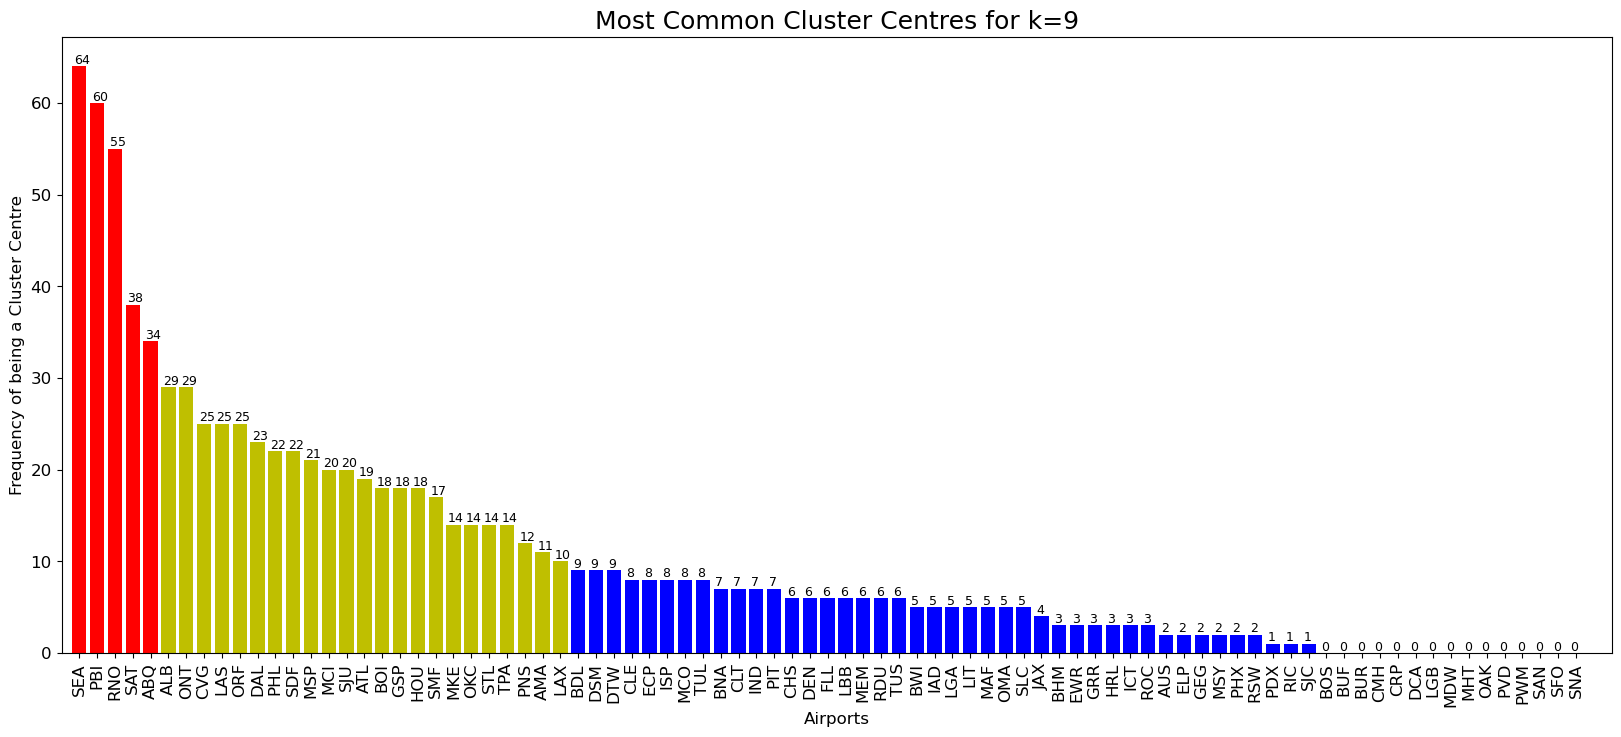

In [166]:
#New dictionary that contains sorted frequencies
common_centres_9=dict(sorted(cc_frequency_9.items(),key=lambda x:x[1],reverse=True))

#Defining a colour bar
colors_9=[]
for i in common_centres_9.values():
    if i>=30:
        colors_9.append('r')
    elif i>=10:
        colors_9.append('y')
    else:
        colors_9.append('b')     

#Bar Plot
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(20,8))
plt.bar(common_centres_9.keys(), common_centres_9.values(),color=colors_9)
plt.xticks(rotation='vertical')
plt.xlim(-1,86)
plt.rcParams.update({'font.size': 9})
for index, value in enumerate(common_centres_9.values()):
    plt.text(index-0.3,value+0.3,str(value))
plt.rcParams.update({'font.size': 15})
plt.title("Most Common Cluster Centres for k=9")
plt.xlabel("Airports")
plt.ylabel("Frequency of being a Cluster Centre")
plt.show()

In [186]:
without_weight={'SEA': 68, 'SAT': 57, 'PBI': 55, 'RNO': 46, 'PHL': 39, 'MKE': 35, 'LAS': 31, 'ATL': 26, 'ORF': 22, 'BWI': 21, 'MCI': 19, 'STL': 18, 'MAF': 17, 'PDX': 17, 'ECP': 16, 'LBB': 16, 'JAX': 15, 'IND': 13, 'PNS': 13, 'MSP': 11, 'MCO': 10, 'SJU': 9, 'BOI': 8, 'MEM': 8, 'ONT': 8, 'SMF': 8, 'RSW': 7, 'ALB': 6, 'IAD': 6, 'SDF': 6, 'CLT': 5, 'LIT': 5, 'AMA': 4, 'CMH': 4, 'CVG': 4, 'DAL': 4, 'ELP': 3, 'LAX': 3, 'PHX': 3, 'TUL': 3, 'ABQ': 2, 'BDL': 2, 'BNA': 2, 'DCA': 2, 'DEN': 2, 'DSM': 2, 'MDW': 2, 'MSY': 2, 'PIT': 2, 'RDU': 2, 'BHM': 1, 'BUF': 1, 'CHS': 1, 'CLE': 1, 'DTW': 1, 'FLL': 1, 'GRR': 1, 'GSP': 1, 'HOU': 1, 'ISP': 1, 'LGA': 1, 'AUS': 0, 'BOS': 0, 'BUR': 0, 'CRP': 0, 'EWR': 0, 'GEG': 0, 'HRL': 0, 'ICT': 0, 'LGB': 0, 'MHT': 0, 'OAK': 0, 'OKC': 0, 'OMA': 0, 'PVD': 0, 'PWM': 0, 'RIC': 0, 'ROC': 0, 'SAN': 0, 'SFO': 0, 'SJC': 0, 'SLC': 0, 'SNA': 0, 'TPA': 0, 'TUS': 0}

In [ ]:
with_weight_k_7={'PBI': 74, 'SEA': 65, 'SAT': 58, 'LAS': 52, 'RNO': 44, 'BWI': 33, 'STL': 30, 'MKE': 29, 'ATL': 27, 'PHL': 19, 'LIT': 17, 'ORF': 16, 'CVG': 14, 'HOU': 13, 'MEM': 13, 'ABQ': 12, 'ALB': 12, 'BOI': 11, 'ONT': 11, 'AMA': 10, 'ECP': 10, 'IAD': 10, 'LGA': 7, 'MAF': 7, 'SMF': 7, 'DCA': 6, 'DEN': 6, 'GSP': 6, 'PDX': 6, 'PNS': 5, 'FLL': 4, 'LAX': 4, 'MSP': 4, 'SDF': 4, 'SJU': 4, 'BUF': 3, 'HRL': 3, 'LBB': 3, 'MSY': 3, 'OMA': 3, 'PHX': 3, 'TPA': 3, 'TUL': 3, 'AUS': 2, 'CMH': 2, 'DTW': 2, 'GEG': 2, 'IND': 2, 'OKC': 2, 'RIC': 2, 'ROC': 2, 'RSW': 2, 'BHM': 1, 'BNA': 1, 'ICT': 1, 'ISP': 1, 'MCI': 1, 'PIT': 1, 'RDU': 1, 'SLC': 1, 'BDL': 0, 'BOS': 0, 'BUR': 0, 'CHS': 0, 'CLE': 0, 'CLT': 0, 'CRP': 0, 'DAL': 0, 'DSM': 0, 'ELP': 0, 'EWR': 0, 'GRR': 0, 'JAX': 0, 'LGB': 0, 'MCO': 0, 'MDW': 0, 'MHT': 0, 'OAK': 0, 'PVD': 0, 'PWM': 0, 'SAN': 0, 'SFO': 0, 'SJC': 0, 'SNA': 0, 'TUS': 0}

In [ ]:
with_weight_k_9={'SEA': 64, 'PBI': 60, 'RNO': 55, 'SAT': 38, 'ABQ': 34, 'ALB': 29, 'ONT': 29, 'CVG': 25, 'LAS': 25, 'ORF': 25, 'DAL': 23, 'PHL': 22, 'SDF': 22, 'MSP': 21, 'MCI': 20, 'SJU': 20, 'ATL': 19, 'BOI': 18, 'GSP': 18, 'HOU': 18, 'SMF': 17, 'MKE': 14, 'OKC': 14, 'STL': 14, 'TPA': 14, 'PNS': 12, 'AMA': 11, 'LAX': 10, 'BDL': 9, 'DSM': 9, 'DTW': 9, 'CLE': 8, 'ECP': 8, 'ISP': 8, 'MCO': 8, 'TUL': 8, 'BNA': 7, 'CLT': 7, 'IND': 7, 'PIT': 7, 'CHS': 6, 'DEN': 6, 'FLL': 6, 'LBB': 6, 'MEM': 6, 'RDU': 6, 'TUS': 6, 'BWI': 5, 'IAD': 5, 'LGA': 5, 'LIT': 5, 'MAF': 5, 'OMA': 5, 'SLC': 5, 'JAX': 4, 'BHM': 3, 'EWR': 3, 'GRR': 3, 'HRL': 3, 'ICT': 3, 'ROC': 3, 'AUS': 2, 'ELP': 2, 'GEG': 2, 'MSY': 2, 'PHX': 2, 'RSW': 2, 'PDX': 1, 'RIC': 1, 'SJC': 1, 'BOS': 0, 'BUF': 0, 'BUR': 0, 'CMH': 0, 'CRP': 0, 'DCA': 0, 'LGB': 0, 'MDW': 0, 'MHT': 0, 'OAK': 0, 'PVD': 0, 'PWM': 0, 'SAN': 0, 'SFO': 0, 'SNA': 0}

In [ ]:
#Plotting the clusters
        #plt.scatter(coordinates[:,1],coordinates[:,0],c=pd.Categorical(labels).codes,cmap=plt.cm.rainbow)
        #plt.scatter(centres_coords[:,1],centres_coords[:,0],c='k',marker='o',s=300,alpha=0.5)
        #for i,txt in enumerate(codes):
        #    plt.annotate(txt,(coordinates[i,1],coordinates[i,0]))
        #plt.show();
        #print('Initial centres =',initial_centres)    
        #print('Final centres =',set(new_centres))
        #print('No. of iterations =',counter)
        
#Plotting the centres        
#plt.scatter(centres_coords[:,1],centres_coords[:,0],c='k',marker='o',s=300,alpha=0.5)
        #for i,txt in enumerate(new_centres):
        #    plt.annotate(txt,(centres_coords[i,1],centres_coords[i,0]))
        #plt.title('Iteration '+str(counter+1))
        #plt.show();